# Identifying Missing Data in the Caltrans/PeMS Dataset

The California Department of Transportation (Caltrans) collects data that describes the flow of traffic on California freeways. Caltrans stores these data in a database called PeMS. The data describe the number of counts per unit time meaured by roughly 45,000 sensors on a 30-second cadence. The type of sensor varies considerably, e.g. radar and magnetometers (see Chapter 1 of the [Introduction to PeMS User Guide](https://pems.dot.ca.gov/Papers/PeMS_Intro_User_Guide_v6.pdf)). 

In some cases, these data are missing. Faulty or broken sensors do not collect data. Or sensor data is not wirelessly transmitted back to PeMS. In addition, Caltrans performs some calculations to convert these raw sensor data into physical observables such as speed. These calculations include some assumptions such as the length of the vehicle, or $g$. Based on the quality of the assumption, these data can include errors.

In this notebook, we will take a look at the nature of the missing data. Some questions to ask:
1. Are all the data available for District 5 from the District Map and County Chart during 2023?
2. If data are missing, do they occur in any spatial or temporal clusters?
3. Are there any outliers or unexpected values in the data?
4. Are all the data available for all the available districts in recent decade, 2013-2023? And again, is there any pattern to the missing data? Are there any odd values?

### Setup

In [195]:
import ibis
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import ibis.selectors as s
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from dotenv import load_dotenv
from functools import reduce
from datetime import datetime as dt_obj
from datetime import date
from datetime import timedelta

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 3000)

In [2]:
load_dotenv(override=True)
USERNAME = os.getenv('USERNAME')
PASSWORD = os.getenv('PASSWORD')

In [3]:
con = ibis.snowflake.connect(
    user=USERNAME,
    password=PASSWORD,
    role='TRANSFORMER_DEV',
    warehouse='TRANSFORMING_XS_DEV',
    account="VSB79059-DSE_CALTRANS_PEMS",
    database="RAW_PRD/CLEARINGHOUSE",
)

In [5]:
station_metadata = con.table("STATION_META");
station_raw = con.table("STATION_RAW");
#station_status = con.table("STATION_STATUS");

In [6]:
station_metadata_df = station_metadata.execute(limit=10)
station_raw_df = station_raw.execute(limit=10)
#station_status_df = station_status.execute(limit=10)

In [7]:
station_metadata_df

,FILENAME,ID,FWY,DIR,DISTRICT,COUNTY,CITY,STATE_PM,ABS_PM,LATITUDE,LONGITUDE,LENGTH,TYPE,LANES,NAME,USER_ID_1,USER_ID_2,USER_ID_3,USER_ID_4
0,clhouse/meta/d08/2024/01/d08_text_meta_2024_01...,801230,10,W,8,71,48788,.591,47.356,34.082004,-117.699964,0.845,ML,4,MONTE VISTA AVE,1,None,None,None
1,clhouse/meta/d08/2024/01/d08_text_meta_2024_01...,801231,10,W,8,71,48788,.591,47.356,34.082004,-117.699964,NaN,OR,2,MONTE VISTA AVE,1,None,None,None
2,clhouse/meta/d08/2024/01/d08_text_meta_2024_01...,801232,10,E,8,71,48788,.721,47.486,34.082149,-117.697705,0.996,ML,4,MONTE VISTA AVE,1,None,None,None
3,clhouse/meta/d08/2024/01/d08_text_meta_2024_01...,801233,10,E,8,71,48788,.721,47.486,34.082149,-117.697705,NaN,OR,2,MONTE VISTA AVE,1,None,None,None
4,clhouse/meta/d08/2024/01/d08_text_meta_2024_01...,801234,10,W,8,71,48788,1.168,47.933,34.085065,-117.690768,0.660,ML,4,CENTRAL AVE,1,None,None,None
5,clhouse/meta/d08/2024/01/d08_text_meta_2024_01...,801236,10,W,8,71,48788,1.168,47.933,34.085065,-117.690768,NaN,OR,2,CENTRAL AVE,1,None,None,None
6,clhouse/meta/d08/2024/01/d08_text_meta_2024_01...,801237,10,E,8,71,48788,1.342,48.107,34.086058,-117.687970,0.595,ML,4,CENTRAL AVE,1,None,None,None
7,clhouse/meta/d08/2024/01/d08_text_meta_2024_01...,801238,10,E,8,71,48788,1.342,48.107,34.086058,-117.687970,NaN,OR,2,CENTRAL AVE,1,None,None,None
8,clhouse/meta/d08/2024/01/d08_text_meta_2024_01...,801239,10,E,8,71,81344,1.912,48.677,34.087192,-117.678250,0.523,ML,4,BENSON AVE,1,None,None,None
9,clhouse/meta/d08/2024/01/d08_text_meta_2024_01...,801240,10,W,8,71,81344,1.912,48.677,34.087372,-117.678335,0.544,ML,4,BENSON AVE,1,None,None,None


In [8]:
station_raw_df

,FILENAME,SAMPLE_TIMESTAMP,SAMPLE_DATE,ID,FLOW_1,OCCUPANCY_1,SPEED_1,FLOW_2,OCCUPANCY_2,SPEED_2,FLOW_3,OCCUPANCY_3,SPEED_3,FLOW_4,OCCUPANCY_4,SPEED_4,FLOW_5,OCCUPANCY_5,SPEED_5,FLOW_6,OCCUPANCY_6,SPEED_6,FLOW_7,OCCUPANCY_7,SPEED_7,FLOW_8,OCCUPANCY_8,SPEED_8
0,clhouse/raw/d06/2018/11/d06_text_station_raw_2...,2018-11-12 21:35:11,2018-11-12,602408,2,0.013,77.0,2.0,0.011,75.0,2.0,0.059,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,clhouse/raw/d08/2018/11/d08_text_station_raw_2...,2018-11-12 21:03:05,2018-11-12,816010,9,0.061,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,clhouse/raw/d08/2018/11/d08_text_station_raw_2...,2018-11-12 21:28:06,2018-11-12,801250,7,0.054,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,clhouse/raw/d12/2018/11/d12_text_station_raw_2...,2018-11-12 22:46:39,2018-11-12,1203329,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,clhouse/raw/d08/2018/11/d08_text_station_raw_2...,2018-11-12 23:41:09,2018-11-12,808586,2,0.009,96.0,3.0,0.015,NaN,2.0,0.011,NaN,3.0,0.061,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,clhouse/raw/d12/2018/11/d12_text_station_raw_2...,2018-11-12 00:03:02,2018-11-12,1211624,0,0.000,NaN,0.0,0.000,NaN,0.0,0.000,NaN,1.0,0.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,clhouse/raw/d12/2018/11/d12_text_station_raw_2...,2018-11-12 22:46:39,2018-11-12,1203361,4,0.018,NaN,3.0,0.013,NaN,3.0,0.016,NaN,4.0,0.022,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,clhouse/raw/d12/2018/11/d12_text_station_raw_2...,2018-11-12 06:17:03,2018-11-12,1203979,3,0.037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,clhouse/raw/d08/2018/11/d08_text_station_raw_2...,2018-11-12 18:23:05,2018-11-12,824428,17,0.151,56.0,17.0,0.169,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,clhouse/raw/d10/2018/11/d10_text_station_raw_2...,2018-11-12 17:44:14,2018-11-12,1097610,4,0.056,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Question 1. Are all the data available for District 5 from the [District Map and County Chart](https://cwwp2.dot.ca.gov/documentation/district-map-county-chart.htm) during 2023?

1. Filter the station metadata file to look at `DISTRICT` values of 5.
2. Strip away all old versions of the data by selecting the most recent unique ID.
3. Select all station IDs within District 5 that took data in 2023.
4. Merge the raw and metadata files on the keyword `ID`.
5. Look at the keyword `SAMPLE_TIMESTAMP` in the `STATION_RAW` table to plot the timestamps for any given freeway.

##### 1. Filter the station metadata file to look at `DISTRICT` values of 5.

In [9]:
district_5_filter = station_metadata.filter(station_metadata["DISTRICT"] == "5")

In [10]:
district_5_df = district_5_filter.execute()

##### 2. Strip away all old versions of the data by selecting the most recent unique ID.

Identify the number of unique values of ID in District 5.

In [11]:
print('There are {} unique values of ID in District 5.'.format(district_5_df['ID'].nunique()))

There are 706 unique values of ID in District 5.


Construct a new column called `DATA_VERSION`.

In [12]:
district_5_df['DATA_VERSION'] = np.NaN

Extract the date from the `FILENAME` keyword. Populate these dates in the `DATA_VERSION` keyword.

In [13]:
data_version = [dt_obj.strptime(filename[39:49], '%Y_%m_%d') for filename in district_5_df['FILENAME'].values]

In [14]:
district_5_df['DATA_VERSION'] = data_version

Select the most recent `DATA_VERSION` for each unique ID. Drop the rest. The dataframe `district_5_recent_version_df` contains the most recent metadata values for each station ID.

In [15]:
unique_IDs = district_5_df['ID'].value_counts().index.to_list()

In [16]:
drop_these_rows = []
for i in range(len(unique_IDs)):
    ID_subset = district_5_df[district_5_df['ID'] == unique_IDs[i]]
    index_for_max_value = ID_subset['DATA_VERSION'].idxmax()
    indices_for_rows_to_drop = ID_subset.drop(index_for_max_value).index.to_list()
    drop_these_rows.append(indices_for_rows_to_drop)

In [17]:
drop_these_rows_flattened = list(itertools.chain.from_iterable(drop_these_rows))

In [18]:
district_5_recent_version_df = district_5_df.drop(drop_these_rows_flattened).reset_index(drop=True)

Have some of these data been updated in 2023? Yes.

In [19]:
max(district_5_recent_version_df['DATA_VERSION'])

Timestamp('2023-11-17 00:00:00')

##### 3. Select all station IDs within District 5 that took data in 2023.

In [48]:
# Select dates within the year 2023
date_selection_start = '2023-03-01'
date_selection_end = '2023-03-10'

In [61]:
print(date_selection_start)
print(date_selection_end)

2023-03-01
2023-03-10


In [69]:
date_and_ID_filter = station_raw.select("SAMPLE_DATE","SAMPLE_TIMESTAMP","FILENAME","ID").filter(
    (station_raw["SAMPLE_DATE"] >= '2023-03-01') & (station_raw["SAMPLE_DATE"] < '2023-03-10')
).filter(
    station_raw["FILENAME"].contains("/d05")
).select("ID","SAMPLE_TIMESTAMP")

In [70]:
%%time
out = date_and_ID_filter.execute()

CPU times: user 5.08 s, sys: 1.14 s, total: 6.22 s
Wall time: 25.2 s


In [162]:
# A list of all the station IDs that took data in 2023
IDs_in_D5_with_2023_data = out['ID'].value_counts().index.to_list();
len(IDs_in_D5_with_2023_data)

566

In [163]:
# A list of all the station IDs in District 5
IDs_in_D5 = district_5_recent_version_df["ID"].to_list();
len(IDs_in_D5)

706

In [164]:
# Find unique values within two lists
common_values = list(set(IDs_in_D5_with_2023_data).symmetric_difference(set(IDs_in_D5)))

Why is this?

In [165]:
len(common_values)

146

In [258]:
out[out["ID"] == common_values[0]]

,ID,SAMPLE_TIMESTAMP


Anyway, look at 101 N for now:

In [156]:
merged_df = out.merge(district_5_recent_version_df, on=['ID'], how='left')

In [253]:
dates = merged_df[merged_df["ID"] == common_values[0]].sort_values(["SAMPLE_TIMESTAMP"]).reset_index(drop=True)

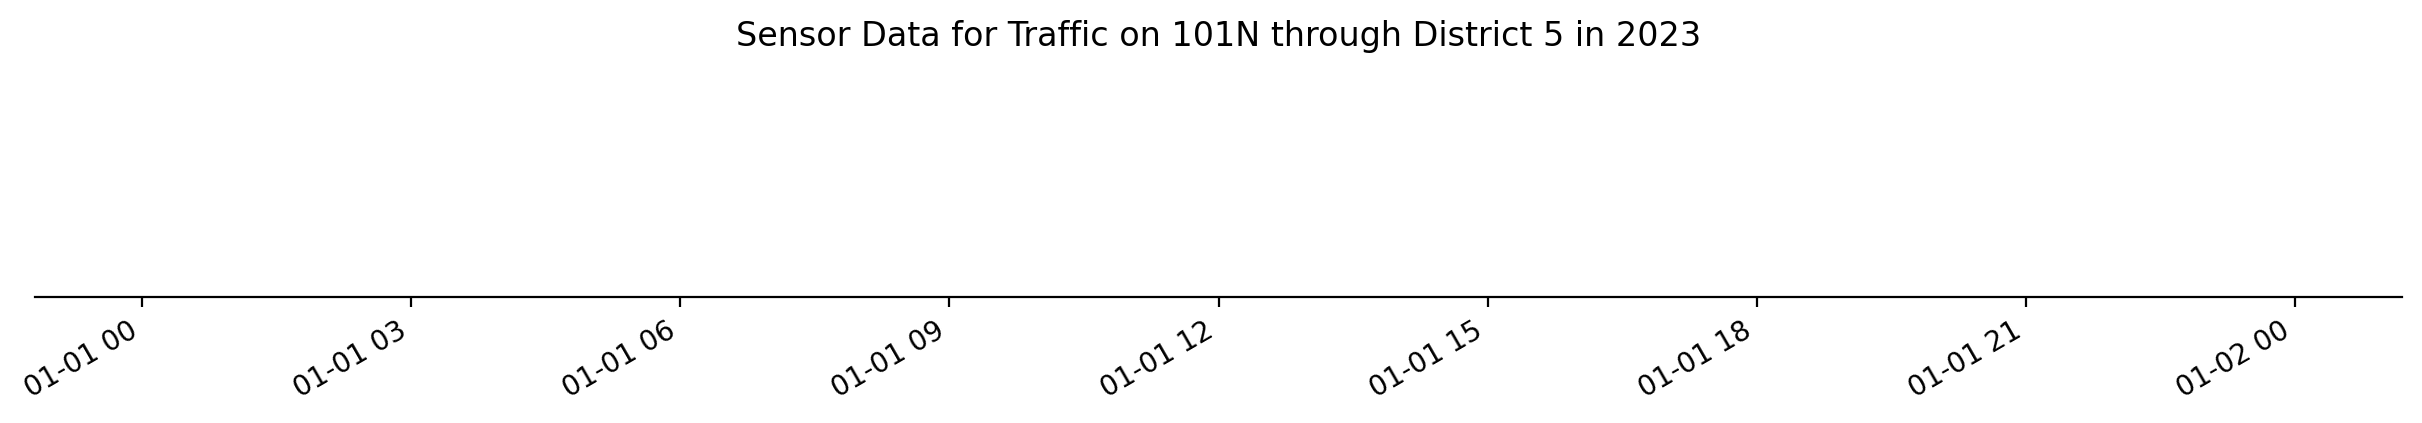

In [254]:
# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(12, 2), layout="constrained")
ax.set(title="Sensor Data for Traffic on 101N through District 5 in 2023")

# Plot timeline
dates = dates["SAMPLE_TIMESTAMP"]
ax.plot(dates, np.zeros_like(dates), "-o", color="blue", markerfacecolor="blue")  # Baseline and markers on it.

# Plot labels
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

# Remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

plt.show()